In [ ]:
pip install tensorflow

In [36]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC
from tensorflow.keras.layers import Resizing,Rescaling, InputLayer, Conv2D,MaxPool2D, Dropout,Dense, Flatten, BatchNormalization, Input
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import L1,L2

In [2]:
BATCH_SIZE=32
IMAGE_SIZE=256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "PlantVillage",
  shuffle=True,
  labels='inferred',
  label_mode='categorical',
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE,
  color_mode='rgb',
  seed=99,
)

Found 1790 files belonging to 3 classes.


In [4]:
class_name=dataset.class_names# they will give you the name of classes 

In [5]:
class_name

['canker', 'chlorosis', 'healthy']

(32, 256, 256, 3)
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]]


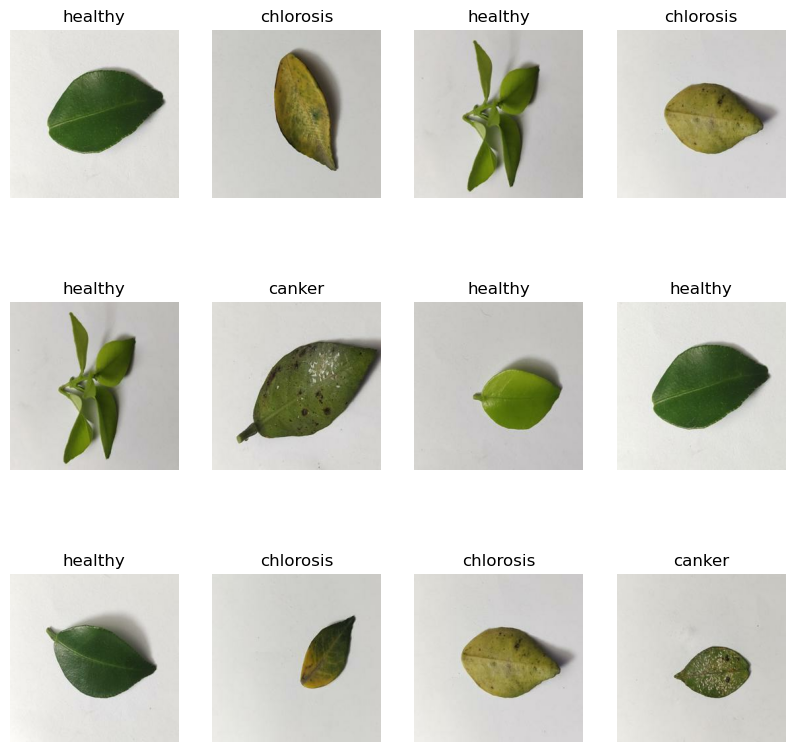

In [6]:
plt.figure(figsize=(10, 10))

for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        # Get the index of the class name corresponding to the one-hot encoded label
        class_index = int(tf.argmax(labels_batch[i]))
        
        plt.title(class_name[class_index])
        plt.axis("off")

plt.show()


In [7]:
# Define split ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

In [8]:
# Function to split dataset
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = len(dataset)
    
    # Calculate split sizes
    train_size = int(TRAIN_RATIO * DATASET_SIZE)
    val_size = int(VAL_RATIO * DATASET_SIZE)
    test_size = int(TEST_RATIO * DATASET_SIZE)

    # Shuffle and split the dataset
    dataset = dataset.shuffle(buffer_size=DATASET_SIZE, reshuffle_each_iteration=False)

    train_dataset = dataset.take(train_size)
    remaining_dataset = dataset.skip(train_size)
    val_dataset = remaining_dataset.take(val_size)
    test_dataset = remaining_dataset.skip(val_size)

    return train_dataset, val_dataset, test_dataset

In [9]:
# Split dataset
train_dataset, val_dataset, test_dataset = splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

In [10]:
training_dataset = (
    train_dataset.prefetch(tf.data.AUTOTUNE)
)

In [11]:
validation_dataset = (
    val_dataset.prefetch(tf.data.AUTOTUNE)
)

In [12]:
resize_rescale_layers = tf.keras.Sequential([
    Resizing(IMAGE_SIZE,IMAGE_SIZE),
    Rescaling(1./255)
])

In [13]:
training_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [14]:
validation_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [15]:
dropout_rate = 0.5
regularization_rate = 0.08
model  = tf.keras.Sequential([
    InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer = L2(0.01)),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
    Dropout(rate = dropout_rate),

#     Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu', kernel_regularizer = L2(0.01)),
#     BatchNormalization(),
#     MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation="relu"),
    BatchNormalization(),
    Dropout(rate = dropout_rate),
    
    Dense(10, activation="relu"),
    BatchNormalization(),
    Dense(3, activation="softmax"),
])


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 6)       168       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 6)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 128, 128, 6)       0         
                                                                 
 flatten (Flatten)           (None, 98304)             0         
                                                                 
 dense (Dense)               (None, 100)              

In [17]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'),TrueNegatives(name='tn'),FalseNegatives(name='fn'),
           BinaryAccuracy(name='Accuracy'), Precision(name = 'precision'), Recall(name='recall'), AUC(name='auc')]

In [18]:
model.compile(
      optimizer="adam",
      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
      #metrics=['accuracy']
      metrics = metrics
)

In [19]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    batch_size=BATCH_SIZE,
    verbose=1,
    epochs=20
)


Epoch 1/20
44/44 [==============================] - 56s 1s/step - loss: 0.4631 - tp: 1170.0000 - fp: 117.0000 - tn: 2695.0000 - fn: 236.0000 - Accuracy: 0.9163 - precision: 0.9091 - recall: 0.8321 - auc: 0.9630 - val_loss: 15.1807 - val_tp: 52.0000 - val_fp: 108.0000 - val_tn: 212.0000 - val_fn: 108.0000 - val_Accuracy: 0.5500 - val_precision: 0.3250 - val_recall: 0.3250 - val_auc: 0.5343
Epoch 2/20
44/44 [==============================] - 55s 1s/step - loss: 0.1658 - tp: 1393.0000 - fp: 9.0000 - tn: 2803.0000 - fn: 13.0000 - Accuracy: 0.9948 - precision: 0.9936 - recall: 0.9908 - auc: 0.9995 - val_loss: 0.2831 - val_tp: 150.0000 - val_fp: 6.0000 - val_tn: 314.0000 - val_fn: 10.0000 - val_Accuracy: 0.9667 - val_precision: 0.9615 - val_recall: 0.9375 - val_auc: 0.9844
Epoch 3/20
44/44 [==============================] - 50s 1s/step - loss: 0.1242 - tp: 1396.0000 - fp: 8.0000 - tn: 2804.0000 - fn: 10.0000 - Accuracy: 0.9957 - precision: 0.9943 - recall: 0.9929 - auc: 0.9999 - val_loss: 0.

In [20]:
scores=model.evaluate(test_dataset)

7/7 [==============================] - 3s 272ms/step - loss: 7.4046 - tp: 188.0000 - fp: 36.0000 - tn: 412.0000 - fn: 36.0000 - Accuracy: 0.8929 - precision: 0.8393 - recall: 0.8393 - auc: 0.8704


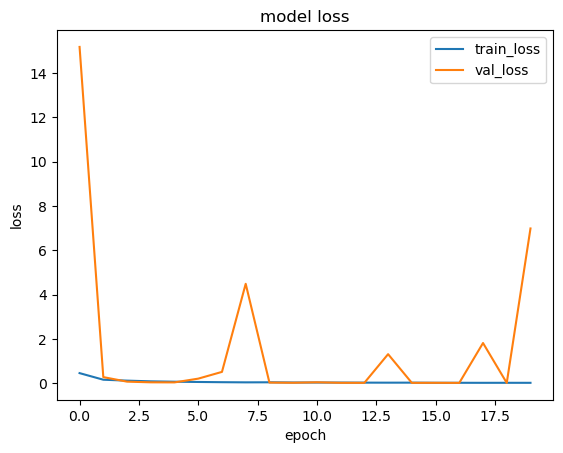

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

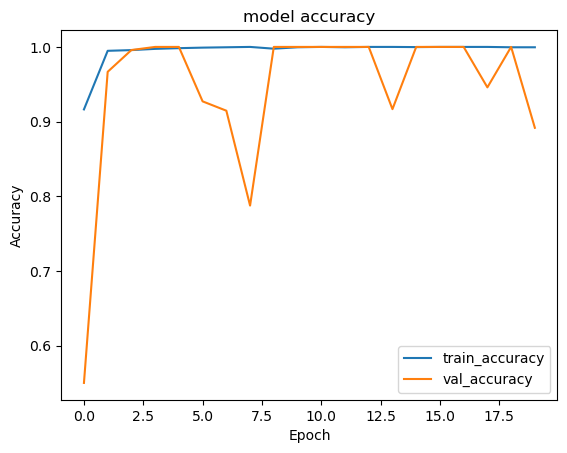

In [28]:
plt.plot(history.history['Accuracy'])
plt.plot(history.history['val_Accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [44]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)#create batch
    predictions=model.predict(img_array)
    predicted_class=class_name[np.argmax(batch_prediction[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

In [53]:
from ipywidgets import FileUpload
from IPython.display import display, Image as IPyImage
import numpy as np
import tensorflow as tf
from PIL import Image
import io


FileUpload(value={}, accept='image/*', description='Upload')

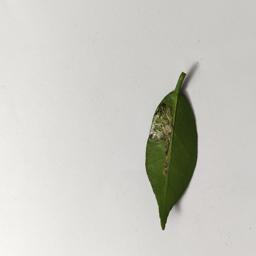

1/1 [==============================] - 0s 31ms/step
Predicted class: Cranker, Confidence: 99.97%


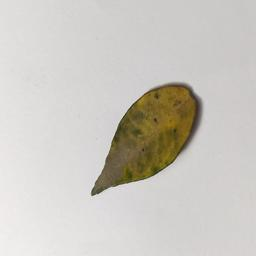

1/1 [==============================] - 0s 53ms/step
Predicted class: Chlorosis, Confidence: 99.92%


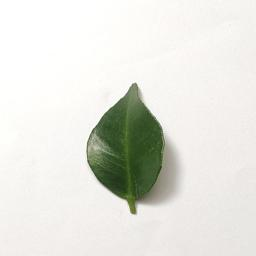

1/1 [==============================] - 0s 47ms/step
Predicted class: Healthy, Confidence: 99.81%


In [54]:
upload = FileUpload(accept='image/*', multiple=False)
display(upload)

In [55]:
# Replace `model` with your actual model variable
def predict_image_with_model(img_data, model):
    # Load and preprocess the image
    img = Image.open(io.BytesIO(img_data)).resize((256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    
    # Predict
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions[0])
    confidence = round(100 * np.max(predictions[0]), 2)
    
    # Translate prediction into your labels
    labels = {0: 'Cranker', 1: 'Chlorosis', 2: 'Healthy'}
    predicted_label = labels[predicted_class]
    
    return predicted_label, confidence


In [56]:
def on_upload_change(change):
    if not upload.value:
        print("Please upload an image.")
        return
    
    # Get the uploaded file's content
    input_file = next(iter(upload.value.values()))
    content = input_file['content']
    
    # Display the uploaded image
    display(IPyImage(data=content))
    
    # Predict and display results
    predicted_class, confidence = predict_image_with_model(content, model)  # Ensure your model variable is correctly named
    print(f"Predicted class: {predicted_class}, Confidence: {confidence}%")

upload.observe(on_upload_change, names='_counter')
